In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt




import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline


In [2]:
def load_sess_df(path, folder, basedir):
    sess_df = pd.read_csv(basedir / 'sessions.csv')
    
    sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['condition'] + '_' + folder for _, row in sess_df.iterrows()]
    sess_df['mean offset'] = [np.nan for _, row in sess_df.iterrows()]
    sess_df['offset var.'] = [np.nan for _, row in sess_df.iterrows()]
    sess_df['mean vec. len'] = [np.nan for _, row in sess_df.iterrows()]
    sess_df['folder'] = folder
    sess_df['basedir'] = str(path.parent)
    return sess_df

basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f/remapping')
base_sess_df = load_sess_df(basedir / 'sessions.csv', 'base', basedir)
mask = []
for _, row in base_sess_df.iterrows():
    if row['condition'] in set(['epinastine', 'yohimbine']):
        mask.append(False)
    else:
        mask.append(True)
base_sess_df = base_sess_df.loc[mask].reset_index(drop=True)


basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f_hcKCR1')
hckcr_sess_df = load_sess_df(basedir / 'sessions.csv', 'hckcr', basedir)
# sess_df = load_sess_df(basedir / 'sessions.csv', 'hckcr', basedir)


# min_cols = ['fly_id', 'date', 'fly', 'sess', 'condition', 'scan_type', 'usable', 'folder', 'basedir', 'mean offset', 'offset var.', 'mean vec. len']
sess_df = pd.concat([base_sess_df, hckcr_sess_df], ignore_index=True)

In [3]:
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/GOF_combined')
figfolder.mkdir(parents=True, exist_ok=True)

In [4]:
def load_row(row):
    outdir = pathlib.PurePath( pathlib.Path(row['basedir']) / row['condition'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    return st2p.preprocessing.EBImagingSession.from_file(outdir)

In [5]:
for index,row in sess_df.iterrows():
    ts = nmp.session.GetTS(load_row(row))
    
    
    offset_c_mu = ts.offset_c.mean()
    
    sess_df.loc[index, 'mean offset'] = np.angle(offset_c_mu)
    sess_df.loc[index, 'mean vec. len'] = np.abs(offset_c_mu)
    sess_df.loc[index, 'offset var.'] = sp.stats.circvar(ts.offset)

In [6]:
# deg0 = sess_df.loc[(sess_df['condition'] == 'exp') & (sess_df['scan_type'] == 'post_0deg'),'mean offset'] 
# deg180 = sess_df.loc[(sess_df['condition'] == 'exp') & (sess_df['scan_type'] == 'post_180deg'),'mean offset']

# fig, ax = plt.subplots(figsize=(3, 3))
# ax.hist(deg0, bins=30, density=True, alpha=0.5, label='0 deg')
# ax.hist(deg180, bins=30, density=True, alpha=0.5, label='180 deg')

In [7]:
def stack_opto_responses(df, condition, folder, scan_type):
    """Stack opto responses for a given condition and scan type."""
    return np.stack([nmp.remapping.get_opto_resp(load_row(row)) for _, row in df.loc[(df['condition']==condition) & \
                                                                                          (df['scan_type']==scan_type) & \
                                                                                          (df['folder']==folder)].iterrows()])

opto_responses = {
    'el chrimson': {'remap_0deg': [], 'remap_180deg': [], 'combined':[]}, 
    'no chrimson': {'remap_0deg': [], 'remap_180deg': [], 'combined': []}, 
    'novis_control': {'remap_novis': []},
    'epg hckcr': {'remap_0deg': [], 'remap_180deg': [], 'combined': []},
    'el chrimson, epg hckcr': {'remap_0deg': [], 'remap_180deg': [], 'combined': []},
}

##
opto_responses['el chrimson']['remap_0deg'] = stack_opto_responses(sess_df, 'remap', 'base', 'remap_0deg')
opto_responses['no chrimson']['remap_0deg'] = stack_opto_responses(sess_df, 'no_chrimson', 'base', 'remap_0deg')
opto_responses['epg hckcr']['remap_0deg'] = stack_opto_responses(sess_df, 'no_cschrimson', 'hckcr', 'remap_0deg')
opto_responses['el chrimson, epg hckcr']['remap_0deg'] = stack_opto_responses(sess_df, 'exp', 'hckcr', 'remap_0deg')

##
opto_responses['el chrimson']['remap_180deg'] = stack_opto_responses(sess_df, 'remap', 'base', 'remap_180deg')
opto_responses['no chrimson']['remap_180deg'] = stack_opto_responses(sess_df, 'no_chrimson', 'base', 'remap_180deg')
opto_responses['epg hckcr']['remap_180deg'] = stack_opto_responses(sess_df, 'no_cschrimson', 'hckcr', 'remap_180deg')
opto_responses['el chrimson, epg hckcr']['remap_180deg'] = stack_opto_responses(sess_df, 'exp', 'hckcr', 'remap_180deg')

##
opto_responses['novis_control']['remap_novis'] = stack_opto_responses(sess_df, 'novis_control', 'base', 'remap_novis')

##
opto_responses['el chrimson']['combined'] = (opto_responses['el chrimson']['remap_0deg'] + opto_responses['el chrimson']['remap_180deg'])/2
opto_responses['no chrimson']['combined'] = (opto_responses['no chrimson']['remap_0deg'] + opto_responses['no chrimson']['remap_180deg'])/2
opto_responses['epg hckcr']['combined'] = (opto_responses['epg hckcr']['remap_0deg'] + opto_responses['epg hckcr']['remap_180deg'])/2
opto_responses['el chrimson, epg hckcr']['combined'] = (opto_responses['el chrimson, epg hckcr']['remap_0deg'] + opto_responses['el chrimson, epg hckcr']['remap_180deg'])/2


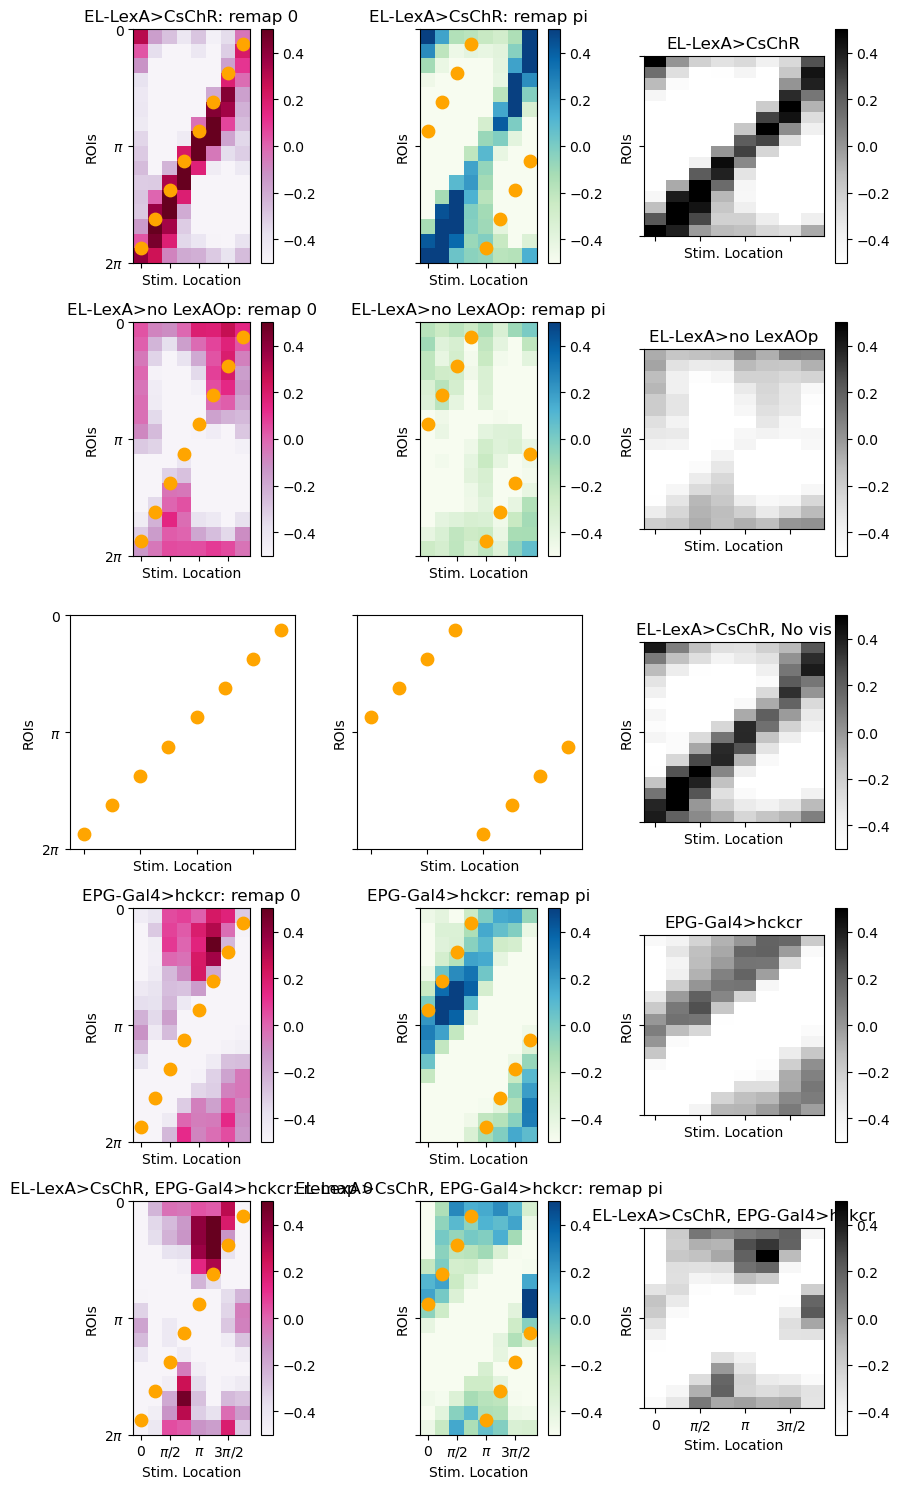

In [8]:
fig, ax = plt.subplots(5,3,figsize=[9,15],sharex=True,sharey=True)

h = ax[0,0].imshow(np.nanmean(opto_responses['el chrimson']['remap_0deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[0,0])
h = ax[0,1].imshow(np.nanmean(opto_responses['el chrimson']['remap_180deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[0,1])
h = ax[0,2].imshow(np.nanmean(opto_responses['el chrimson']['combined'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[0,2])

ax[0, 0].set_title('EL-LexA>CsChR: remap 0')
ax[0, 1].set_title('EL-LexA>CsChR: remap pi')
ax[0, 2].set_title('EL-LexA>CsChR')


h = ax[1,0].imshow(np.nanmean(opto_responses['no chrimson']['remap_0deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[1,0])
h = ax[1,1].imshow(np.nanmean(opto_responses['no chrimson']['remap_180deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[1,1])
h = ax[1,2].imshow(np.nanmean(opto_responses['no chrimson']['combined'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[1,2])

ax[1, 0].set_title('EL-LexA>no LexAOp: remap 0')
ax[1, 1].set_title('EL-LexA>no LexAOp: remap pi')
ax[1, 2].set_title('EL-LexA>no LexAOp')

h = ax[2,2].imshow(np.nanmean(opto_responses['novis_control']['remap_novis'],axis=(0,3)), aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[2,2])

ax[2,2].set_title('EL-LexA>CsChR, No vis')

h = ax[3,0].imshow(np.nanmean(opto_responses['epg hckcr']['remap_0deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[3,0])
h = ax[3,1].imshow(np.nanmean(opto_responses['epg hckcr']['remap_180deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[3,1])
h = ax[3,2].imshow(np.nanmean(opto_responses['epg hckcr']['combined'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[3,2])

ax[3, 0].set_title('EPG-Gal4>hckcr: remap 0')
ax[3, 1].set_title('EPG-Gal4>hckcr: remap pi')
ax[3, 2].set_title('EPG-Gal4>hckcr')

h = ax[4,0].imshow(np.nanmean(opto_responses['el chrimson, epg hckcr']['remap_0deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[4,0])
h = ax[4,1].imshow(np.nanmean(opto_responses['el chrimson, epg hckcr']['remap_180deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[4,1])
h = ax[4,2].imshow(np.nanmean(opto_responses['el chrimson, epg hckcr']['combined'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[4,2])
ax[4, 0].set_title('EL-LexA>CsChR, EPG-Gal4>hckcr: remap 0')
ax[4, 1].set_title('EL-LexA>CsChR, EPG-Gal4>hckcr: remap pi')
ax[4, 2].set_title('EL-LexA>CsChR, EPG-Gal4>hckcr')



for r in range(5):
    x = np.arange(8)
    y = np.arange(0,2*np.pi,np.pi/4)[::-1]*8/np.pi+.5
    h = ax[r,0].scatter(x,y,color= 'orange',s=80)


    y = np.roll(y,4)
    ax[r,1].scatter(x,y,color='orange',s=80)
    

for a in ax.flatten():
    a.set_ylabel('ROIs')
    a.set_xlabel('Stim. Location')
    
    a.set_xticks([0,2,4,6], labels=[r'0',r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([-.5,7.5,15.5], labels=[r'0',r'$\pi$', r'2$\pi$'])

fig.tight_layout()
fig.savefig(figfolder / 'opto_responses.pdf', bbox_inches='tight', dpi=300)


In [9]:
opto_resp_al = {}

for ck in opto_responses.keys():
    opto_resp_al[ck] = {}
    for rk in opto_responses[ck].keys():
        opto = np.copy(opto_responses[ck][rk])
        for i in range(8):
            opto[:,:,i,:] = np.roll(opto[:,:,i,:],2*i-8, axis=1)
            
        opto_resp_al[ck][rk] = opto

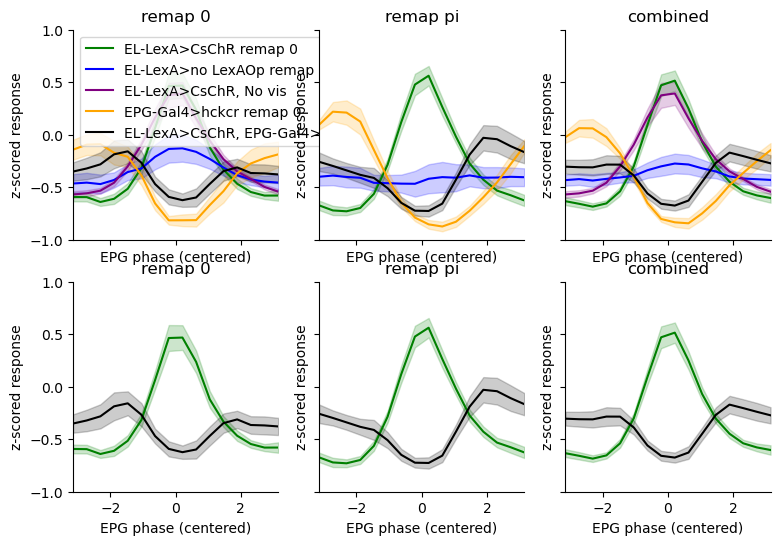

In [10]:
def get_mu_sem(opto_resp_al, condition, scan_type):
    """Get mean and SEM for a given condition and scan type."""
    resp = opto_resp_al[condition][scan_type].mean(axis=(2,3))
    mu = resp.mean(axis=0)
    sem = sp.stats.sem(resp, axis=0)
    return mu, sem



fig, ax = plt.subplots(2,3, figsize=[9,6], sharex=True, sharey=True)
x = np.linspace(-np.pi, np.pi, num=16)

mu, sem = get_mu_sem(opto_resp_al, 'el chrimson', 'remap_0deg')
ax[0,0].plot(x, mu, color='green', label='EL-LexA>CsChR remap 0')
ax[0,0].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)
ax[1,0].plot(x, mu, color='green', label='EL-LexA>CsChR remap 0')
ax[1,0].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)


mu, sem = get_mu_sem(opto_resp_al, 'el chrimson', 'remap_180deg')
ax[0,1].plot(x, mu, color='green', label='EL-LexA>CsChR remap pi')
ax[0,1].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)
ax[1,1].plot(x, mu, color='green', label='EL-LexA>CsChR remap pi')
ax[1,1].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)

mu, sem = get_mu_sem(opto_resp_al, 'el chrimson', 'combined')
ax[0,2].plot(x, mu, color='green', label='EL-LexA>CsChR combined')
ax[0,2].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)
ax[1,2].plot(x, mu, color='green', label='EL-LexA>CsChR combined')
ax[1,2].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)

mu, sem = get_mu_sem(opto_resp_al, 'no chrimson', 'remap_0deg')
ax[0,0].plot(x, mu, color='blue', label='EL-LexA>no LexAOp remap 0')
ax[0,0].fill_between(x, mu-sem, mu+sem, color='blue', alpha=.2)
mu, sem = get_mu_sem(opto_resp_al, 'no chrimson', 'remap_180deg')
ax[0,1].plot(x, mu, color='blue', label='EL-LexA>no LexAOp remap pi')
ax[0,1].fill_between(x, mu-sem, mu+sem, color='blue', alpha=.2)
mu, sem = get_mu_sem(opto_resp_al, 'no chrimson', 'combined')
ax[0,2].plot(x, mu, color='blue', label='EL-LexA>no LexAOp combined')
ax[0,2].fill_between(x, mu-sem, mu+sem, color='blue', alpha=.2)

mu, sem = get_mu_sem(opto_resp_al, 'novis_control', 'remap_novis')
ax[0,0].plot(x, mu, color='purple', label='EL-LexA>CsChR, No vis')
ax[0,0].fill_between(x, mu-sem, mu+sem, color='purple', alpha=.2)
ax[0,2].plot(x, mu, color='purple', label='EL-LexA>CsChR, No vis')
ax[0,2].fill_between(x, mu-sem, mu+sem, color='purple', alpha=.2)

mu, sem = get_mu_sem(opto_resp_al, 'epg hckcr', 'remap_0deg')
ax[0,0].plot(x, mu, color='orange', label='EPG-Gal4>hckcr remap 0')
ax[0,0].fill_between(x, mu-sem, mu+sem, color='orange', alpha=.2)
mu, sem = get_mu_sem(opto_resp_al, 'epg hckcr', 'remap_180deg')
ax[0,1].plot(x, mu, color='orange', label='EPG-Gal4>hckcr remap pi')
ax[0,1].fill_between(x, mu-sem, mu+sem, color='orange', alpha=.2)
mu, sem = get_mu_sem(opto_resp_al, 'epg hckcr', 'combined')
ax[0,2].plot(x, mu, color='orange', label='EPG-Gal4>hckcr combined')
ax[0,2].fill_between(x, mu-sem, mu+sem, color='orange', alpha=.2)

mu, sem = get_mu_sem(opto_resp_al, 'el chrimson, epg hckcr', 'remap_0deg')
ax[0,0].plot(x, mu, color='black', label='EL-LexA>CsChR, EPG-Gal4>hckcr remap 0')
ax[0,0].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)
ax[1,0].plot(x, mu, color='black', label='EL-LexA>CsChR, EPG-Gal4>hckcr remap 0')
ax[1,0].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)
mu, sem = get_mu_sem(opto_resp_al, 'el chrimson, epg hckcr', 'remap_180deg')
ax[0,1].plot(x, mu, color='black', label='EL-LexA>CsChR, EPG-Gal4>hckcr remap pi')
ax[0,1].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)
ax[1,1].plot(x, mu, color='black', label='EL-LexA>CsChR, EPG-Gal4>hckcr remap pi')
ax[1,1].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)
mu, sem = get_mu_sem(opto_resp_al, 'el chrimson, epg hckcr', 'combined')
ax[0,2].plot(x, mu, color='black', label='EL-LexA>CsChR, EPG-Gal4>hckcr combined')
ax[0,2].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)
ax[1,2].plot(x, mu, color='black', label='EL-LexA>CsChR, EPG-Gal4>hckcr combined')
ax[1,2].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)




ax[0,0].legend()
ax[0,0].set_title('remap 0')
ax[0,1].set_title('remap pi')
ax[0,2].set_title('combined')
ax[1,0].set_title('remap 0')
ax[1,1].set_title('remap pi')
ax[1,2].set_title('combined')
for a in ax.flatten():
    a.set_xlabel('EPG phase (centered)')
    a.set_ylabel('z-scored response')
    # a.set_xticks([0,2,4,6], labels=[r'0',r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    # a.set_yticks([-1,0,1], labels=[-1,0,1])
    a.set_xlim(-np.pi,np.pi)
    a.set_ylim(-1,1)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

# fig.tight_layout()
fig.savefig(figfolder / 'opto_responses_aligned.pdf')


In [11]:
def build_sum_stats(fly_list, conditions, df):
    sum_stats = {'fly_id': [], 'condition': []}
    
    for s in ('baseline', 'post_0deg', 'post_180deg', 'post_novis1', 'post_novis2'):
        sum_stats[f'{s} mean offset'] = []
        sum_stats[f'{s} vec. len'] = []
        sum_stats[f'{s} offset var.'] = []       
    
    
    
    for fly, condition in zip(fly_list, conditions):
        sum_stats['fly_id'].append(fly)
        sum_stats['condition'].append(condition)
        
        if not 'novis' in fly:
            for s in ('baseline', 'post_0deg', 'post_180deg'):
                sum_stats[f'{s} mean offset'].append(df.loc[(df['fly_id']==fly) & (df['scan_type']==s)]['mean offset'].mean())
                sum_stats[f'{s} vec. len'].append(df.loc[(df['fly_id']==fly) & (df['scan_type']==s)]['mean vec. len'].mean())
                sum_stats[f'{s} offset var.'].append(df.loc[(df['fly_id']==fly) & (df['scan_type']==s)]['offset var.'].mean())
            for s in ('post_novis1', 'post_novis2'):
                sum_stats[f'{s} mean offset'].append(np.nan)
                sum_stats[f'{s} vec. len'].append(np.nan)
                sum_stats[f'{s} offset var.'].append(np.nan)
        else:
            # print(fly)
            for s in ('baseline', 'post_novis1', 'post_novis2'):
                sum_stats[f'{s} mean offset'].append(df.loc[(df['fly_id']==fly) & (df['scan_type']==s)]['mean offset'].mean())
                sum_stats[f'{s} vec. len'].append(df.loc[(df['fly_id']==fly) & (df['scan_type']==s)]['mean vec. len'].mean())
                sum_stats[f'{s} offset var.'].append(df.loc[(df['fly_id']==fly) & (df['scan_type']==s)]['offset var.'].mean())
            for s in ('post_0deg', 'post_180deg'):
                sum_stats[f'{s} mean offset'].append(np.nan)
                sum_stats[f'{s} vec. len'].append(np.nan)
                sum_stats[f'{s} offset var.'].append(np.nan)
    return pd.DataFrame(sum_stats)           

In [12]:
flies = sess_df['fly_id'].unique()
conditions = []
for fly in flies:
    row = sess_df.loc[sess_df['fly_id']==fly].iloc[0]
    if row['condition'] == 'remap' and row['folder'] == 'base':
        conditions.append('EL>CsChR')
    elif row['condition'] == 'no_chrimson' and row['folder'] == 'base':
        conditions.append('EL>empty')
    elif row['condition'] == 'novis_control' and row['folder'] == 'base':
        conditions.append('EL>CsChR, No vis')
    elif row['condition'] == 'no_cschrimson' and row['folder'] == 'hckcr':
        conditions.append('EPG>hckcr')
    elif row['condition'] == 'exp' and row['folder'] == 'hckcr':
        conditions.append('EL>CsChR, EPG>hckcr')
        # print(fly)
    else:
        pass

# for f, c in zip(flies, conditions):
#     print(f, c)
sum_stats = build_sum_stats(flies, conditions, sess_df.loc[sess_df['scan_type'].isin(['baseline', 'post_0deg', 'post_180deg', 'post_novis1', 'post_novis2'])])



In [13]:
def plot_row_sum_stats(sum_stats, ax, row, condition):
    stats = sum_stats.loc[sum_stats['condition']==condition].copy()

    if condition != 'EL>CsChR, No vis':
        
        for _, r in stats.iterrows():
            ax[row,0].plot(r['baseline mean offset']*np.ones([2,]), [0, r['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4, linewidth=5)
            
            ax[row,1].plot(r['post_0deg mean offset']*np.ones([2,]), [0, r['post_0deg vec. len']], color=plt.cm.PuRd(.8), alpha=.4, linewidth=5)
            ax[row,1].plot(r['post_180deg mean offset']*np.ones([2,]), [0, r['post_180deg vec. len']], color=plt.cm.GnBu(.8), alpha=.4, linewidth=5)

        baseline_v = stats['baseline vec. len']*(np.cos(stats['baseline mean offset'])+1j*np.sin(stats['baseline mean offset']))
        ax[row,0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=10)

        post_0deg_v = stats['post_0deg vec. len']*(np.cos(stats['post_0deg mean offset'])+1j*np.sin(stats['post_0deg mean offset']))
        ax[row,1].plot(np.angle(post_0deg_v.mean())*np.ones((2,)), np.absolute(post_0deg_v.mean())*np.array([0,1]), 
                    color=plt.cm.PuRd(.8), linewidth=10, label='post_0deg')

        post_180deg_v = stats['post_180deg vec. len']*(np.cos(stats['post_180deg mean offset'])+1j*np.sin(stats['post_180deg mean offset']))
        ax[row,1].plot(np.angle(post_180deg_v.mean())*np.ones((2,)), np.absolute(post_180deg_v.mean())*np.array([0,1]), 
                    color=plt.cm.GnBu(.8), linewidth=10, label='post_180deg')

    else:
        # print(stats.head())
        for _, r in stats.iterrows():
            ax[row, 0].plot(r['baseline mean offset']*np.ones([2,]), [0, r['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4, linewidth=5)
            
            ax[row, 1].plot(r['post_novis1 mean offset']*np.ones([2,]), [0, r['post_novis1 vec. len']], color=plt.cm.PuOr(.2), alpha=.4, linewidth=5)
            ax[row, 1].plot(r['post_novis2 mean offset']*np.ones([2,]), [0, r['post_novis2 vec. len']], color=plt.cm.PuOr(.8), alpha=.4, linewidth=5)

        baseline_v = stats['baseline vec. len']*(np.cos(stats['baseline mean offset'])+1j*np.sin(stats['baseline mean offset']))
        ax[row, 0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=10)

        post_novis1_v = stats['post_novis1 vec. len']*(np.cos(stats['post_novis1 mean offset'])+1j*np.sin(stats['post_novis1 mean offset']))
        ax[row,1].plot(np.angle(post_novis1_v.mean())*np.ones((2,)), np.absolute(post_novis1_v.mean())*np.array([0,1]), 
                    color=plt.cm.PuOr(.2), linewidth=10, label='post_novis1')

        post_novis2_v = stats['post_novis2 vec. len']*(np.cos(stats['post_novis2 mean offset'])+1j*np.sin(stats['post_novis2 mean offset']))
        ax[row,1].plot(np.angle(post_novis2_v.mean())*np.ones((2,)), np.absolute(post_novis2_v.mean())*np.array([0,1]), 
                    color=plt.cm.PuOr(.8), linewidth=10, label='post_novis2')


    ax[row,0].set_title(condition)
    ax[row,1].set_title(condition)

    ax[row,1].legend()    


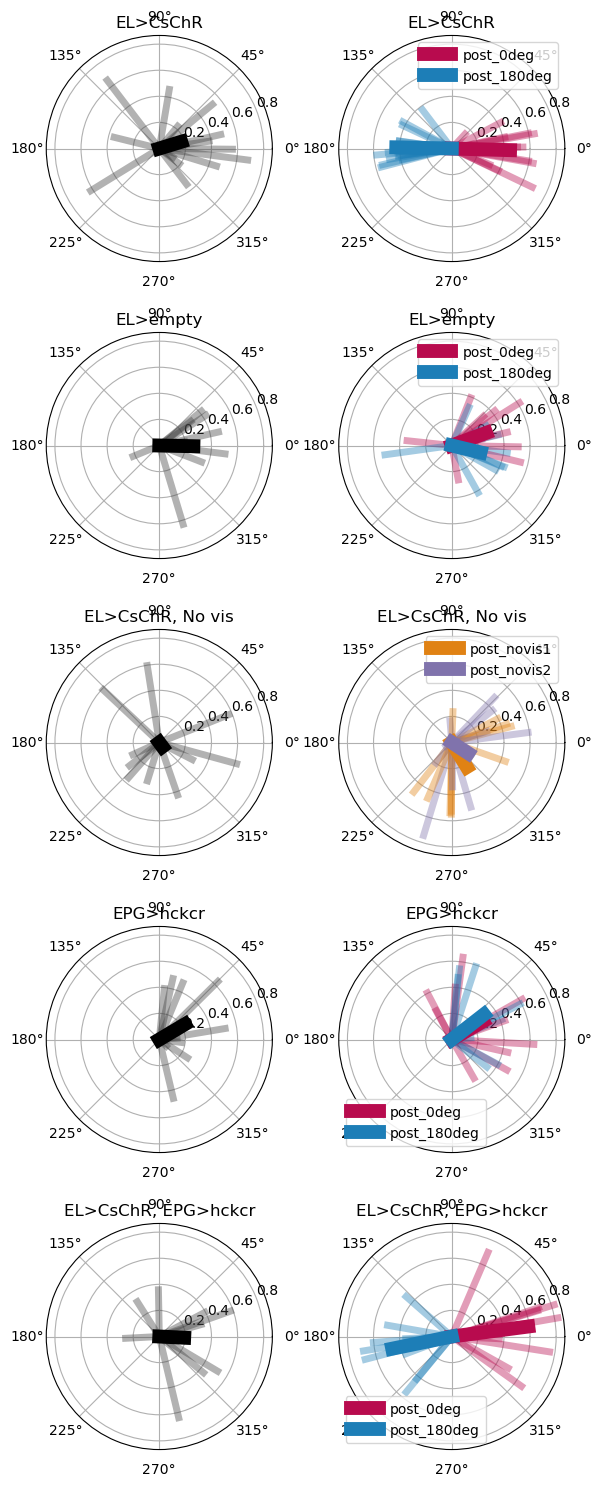

In [14]:
fig, ax = plt.subplots(5, 2, subplot_kw={'projection':'polar'}, figsize=[6,15], sharex=True, sharey=True)

plot_row_sum_stats(sum_stats, ax, 0, 'EL>CsChR')
plot_row_sum_stats(sum_stats, ax, 1, 'EL>empty')
plot_row_sum_stats(sum_stats, ax, 2, 'EL>CsChR, No vis')
plot_row_sum_stats(sum_stats, ax, 3, 'EPG>hckcr')
plot_row_sum_stats(sum_stats, ax, 4, 'EL>CsChR, EPG>hckcr')

fig.tight_layout()
fig.savefig(figfolder / 'sum_stats_polar.pdf')

In [15]:
def avg_diff(tmp_sum_stats, cond):
    if cond!= 'EL>CsChR, No vis':
        diff0 = np.abs(tmp_sum_stats['post_0deg mean offset'] )
        diff180 = np.abs(np.pi - sum_stats['post_180deg mean offset'] )
        diff180 = np.minimum(diff180, 2*np.pi-diff180)       
          
    else:
        diff0 = np.abs(tmp_sum_stats['post_novis1 mean offset'])
        diff0 = np.minimum(diff0, 2*np.pi-diff0)
        
        diff180 = np.abs(np.pi - tmp_sum_stats['post_novis2 mean offset'] )
        diff180 = np.minimum(diff180, 2*np.pi-diff180)
                
    return (diff0+diff180)/2

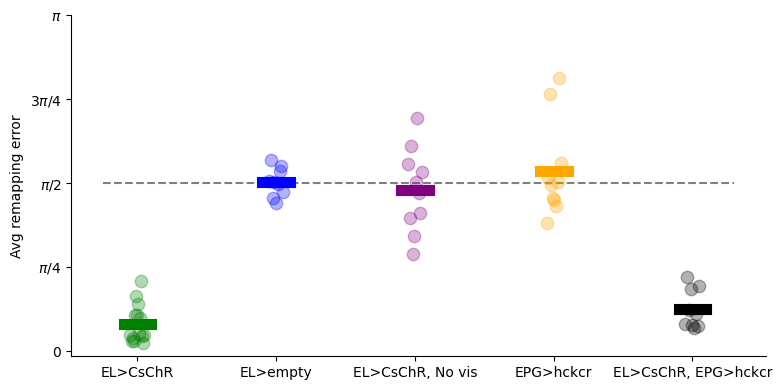

In [18]:
fig, ax = plt.subplots(figsize=[8,4])

cols = ['EL>CsChR', 'EL>empty', 'EL>CsChR, No vis',  'EPG>hckcr', 'EL>CsChR, EPG>hckcr']
colors = ['green', 'blue', 'purple', 'orange', 'black']
avg_diffs = {}
for i, (col, color) in enumerate(zip(cols, colors)):
    sum_stats_col = sum_stats.loc[sum_stats['condition']==col].copy()
    # print(sum_stats_col.head())
    avg_diff_col = avg_diff(sum_stats_col, col)
    avg_diff_col = avg_diff_col.values[~np.isnan(avg_diff_col.values)]

    avg_diffs[col] = avg_diff_col
    
    n = avg_diff_col.shape[0]
    ax.scatter(np.linspace(0,.1,num=n) + i, avg_diff_col, color=color, alpha=.3, s=80)
    ax.plot([-.05+i,.15+i], avg_diff_col.mean()*np.ones([2,]), linewidth=8, color=color, label=col)

ax.plot([-.2,4.35], [np.pi/2, np.pi/2], 'k--', alpha=.5, zorder=-1)

ax.set_xticks(np.arange(5)+.05, labels=cols)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Avg remapping error')
_ = ax.set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4, np.pi], labels=[0, r"$\pi$/4", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])

fig.tight_layout()
fig.savefig(figfolder / 'avg_remapping_error.pdf', bbox_inches='tight', dpi=300)


In [90]:
for col in cols:
    t, p = sp.stats.wilcoxon(avg_diffs[col]-np.pi/2)
    N = avg_diffs[col].shape[0]
    print(f"{col} remap error less than chance (pi/2): N={N}, t={t}, p={p}") 
    

EL>empty remap error less than chance (pi/2): N=9, t=19.0, p=0.734375
EL>CsChR, No vis remap error less than chance (pi/2): N=10, t=24.0, p=0.76953125
EL>CsChR remap error less than chance (pi/2): N=14, t=0.0, p=0.0001220703125
EPG>hckcr remap error less than chance (pi/2): N=10, t=25.0, p=0.845703125
EL>CsChR, EPG>hckcr remap error less than chance (pi/2): N=9, t=0.0, p=0.00390625


In [91]:
t,p = sp.stats.mannwhitneyu(avg_diffs['EL>CsChR'], avg_diffs['EL>CsChR, EPG>hckcr'])
print(f"EL>CsChR vs EL>CsChR, EPG>hckcr: t={t}, p={p}")

EL>CsChR vs EL>CsChR, EPG>hckcr: t=32.0, p=0.05469145227353499
